# บทที่ 6n - การเทรนโมเดลบน Hugging Face พาร์ท 2.1

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/ai-builders/curriculum/blob/main/notebooks/06n_Machine_Translation.ipynb)


In [2]:
!pip install datasets==1.17.0 transformers[sentencepiece]==4.15.0
!pip install accelerate==0.5.1
# To run the training on TPU, you will need to uncomment the followin line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs
!pip install sacrebleu==2.0.0

  Using cached datasets-1.17.0-py3-none-any.whl (306 kB)
  Using cached transformers-4.15.0-py3-none-any.whl (3.4 MB)
  Using cached tokenizers-0.10.3.tar.gz (212 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached sacremoses-0.0.53-py3-none-any.whl
Failed to build tokenizers


  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [51 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-310
      creating build\lib.win-amd64-cpython-310\tokenizers
      copying py_src\tokenizers\__init__.py -> build\lib.win-amd64-cpython-310\tokenizers
      creating build\lib.win-amd64-cpython-310\tokenizers\models
      copying py_src\tokenizers\models\__init__.py -> build\lib.win-amd64-cpython-310\tokenizers\models
      creating build\lib.win-amd64-cpython-310\tokenizers\decoders
      copying py_src\tokenizers\decoders\__init__.py -> build\lib.win-amd64-cpython-310\tokenizers\decoders
      creating build\lib.win-amd64-cpython-310\tokenizers\normalizers
      copying py_src\tokenizers\normalizers\__init__.py -> build\lib.win-amd64-cpython-310\tokenizers\normalizers
      creating build\lib.

'apt' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!git config --global user.email "hugging_face_email"
!git config --global user.name "hugging_face_user_name"

In [5]:
from huggingface_hub import notebook_login

notebook_login()

# โจทย์วันนี้: สร้างเครื่องแปลภาษาจาก EN-FR 

In [6]:
from datasets import load_dataset, load_metric

raw_datasets = load_dataset("kde4", lang1="en", lang2="fr") # ดาต้าเซ็ต en-fr

Using custom data configuration en-fr-lang1=en,lang2=fr


Dataset kde4 downloaded and prepared to C:\Users\Hery\.cache\huggingface\datasets\kde4\en-fr-lang1=en,lang2=fr\0.0.0\243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 21.13it/s]


In [7]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [8]:
raw_datasets['train']['translation'][:3]

[{'en': 'Lauri Watts', 'fr': 'Lauri Watts'},
 {'en': '& Lauri. Watts. mail;', 'fr': '& Lauri. Watts. mail;'},
 {'en': 'ROLES_OF_TRANSLATORS', 'fr': '& traducteurJeromeBlanc;'}]

In [9]:
split_datasets = raw_datasets["train"].train_test_split(train_size=0.9, seed=20)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 189155
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 21018
    })
})

In [10]:
split_datasets["validation"] = split_datasets.pop("test")

In [11]:
split_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 189155
    })
    validation: Dataset({
        features: ['id', 'translation'],
        num_rows: 21018
    })
})

In [14]:
from transformers import pipeline

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr" # โมเดลสำเร็จรูป
translator = pipeline("translation", model=model_checkpoint)

RuntimeError: Failed to import transformers.models.marian.modeling_marian because of the following error (look up to see its traceback):
cannot import name 'dispatch_model' from 'accelerate' (c:\Python310\lib\site-packages\accelerate\__init__.py)

In [ ]:
translator("Default to expanded threads") # ผลการแปล

[{'translation_text': 'Par défaut pour les threads élargis'}]

In [ ]:
split_datasets["train"][1]["translation"] # ผลเฉลย

{'en': 'Default to expanded threads',
 'fr': 'Par défaut, développer les fils de discussion'}

In [ ]:
translator([x['en'] for x in raw_datasets['train']['translation'][3:7]])

[{'translation_text': '2006-02-26 3.5.1'},
 {'translation_text': 'Le plugin Babel & konqueror; vous donne un accès rapide au service de traduction Babelfish.'},
 {'translation_text': 'KDE'},
 {'translation_text': 'kdeaddons'}]

In [ ]:
raw_datasets['train']['translation'][3:7]

[{'en': '2006-02-26 3.5.1', 'fr': '2006-02-26 3.5.1'},
 {'en': 'The Babel & konqueror; plugin gives you quick access to the Babelfish translation service.',
  'fr': 'Le module externe Babel pour & konqueror; vous donne un accès rapide au service de traduction Babelfish.'},
 {'en': 'KDE', 'fr': 'KDE'},
 {'en': 'kdeaddons', 'fr': 'kdeaddons'}]

# การจัดการดาต้า (Processing)

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="tf")

In [ ]:
en_sentence = split_datasets["train"][1]["translation"]["en"]
fr_sentence = split_datasets["train"][1]["translation"]["fr"]

inputs = tokenizer(en_sentence) 
with tokenizer.as_target_tokenizer():
    targets = tokenizer(fr_sentence)

# สิ่งที่ต้องระวัง
ในบางครั้งตัวตัดคำ (tokenizer) ไม่ได้รองรับภาษานั้นๆ จะต้องเลือกใช้ให้ถูกต้องด้วย ซึ่งถ้าไม่ได้ใช้ 
```
with tokenizer.as_target_tokenizer():
```
จะทำให้การตัดคำของเราผิดได้ ยกตัวอย่างเช่น:



In [ ]:
wrong_targets = tokenizer(fr_sentence)
print(tokenizer.convert_ids_to_tokens(wrong_targets["input_ids"]))
print(tokenizer.convert_ids_to_tokens(targets["input_ids"]))

['▁Par', '▁dé', 'f', 'aut', ',', '▁dé', 've', 'lop', 'per', '▁les', '▁fil', 's', '▁de', '▁discussion', '</s>']
['▁Par', '▁défaut', ',', '▁développer', '▁les', '▁fils', '▁de', '▁discussion', '</s>']


In [ ]:
with tokenizer.as_target_tokenizer():
    correct_targets = tokenizer(fr_sentence)
print(tokenizer.convert_ids_to_tokens(correct_targets["input_ids"]))
print(tokenizer.convert_ids_to_tokens(targets["input_ids"]))

['▁Par', '▁défaut', ',', '▁développer', '▁les', '▁fils', '▁de', '▁discussion', '</s>']
['▁Par', '▁défaut', ',', '▁développer', '▁les', '▁fils', '▁de', '▁discussion', '</s>']


In [ ]:
with tokenizer.as_target_tokenizer():
    wrong_source = tokenizer(en_sentence)
print(tokenizer.convert_ids_to_tokens(wrong_source["input_ids"]))
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"]))

['▁De', 'f', 'ault', '▁to', '▁exp', 'ande', 'd', '▁th', 'read', 's', '</s>']
['▁Default', '▁to', '▁expanded', '▁thread', 's', '</s>']


In [ ]:
max_input_length = 128 # ยาวเกินไม่เอา
max_target_length = 128

def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["fr"] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # ใช้ tokenizer ให้ตรงกับภาษานั้นๆ 
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names,
)

  0%|          | 0/190 [00:00<?, ?ba/s]

  0%|          | 0/22 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 189155
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 21018
    })
})

In [ ]:
tokenizer.convert_ids_to_tokens(tokenized_datasets['train']['input_ids'][1])

['▁Default', '▁to', '▁expanded', '▁thread', 's', '</s>']

In [ ]:
tokenizer.convert_ids_to_tokens(tokenized_datasets['train']['labels'][1])

['▁Par',
 '▁défaut',
 ',',
 '▁développer',
 '▁les',
 '▁fils',
 '▁de',
 '▁discussion',
 '</s>']

# คำถามน่าคิด:
คิดว่า token

```
</s>
```

คือ token ไว้บ่งบอกอะไร?

# การ Finetuning โมเดลโดยใช้ฟังก์ชั่นสำเร็จรูป

# สิ่งที่เปลี่ยนไปจากโจทย์ก่อนหน้า?
= จากงานเดิมที่เราต้องใช้ AutoModelForSequenceClassification สำหรับการทำนายประโยค เราจะต้องใช้ Seq2Seq ในการแปลภาษาแทน

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# อะไรคือ Seq2Seq?
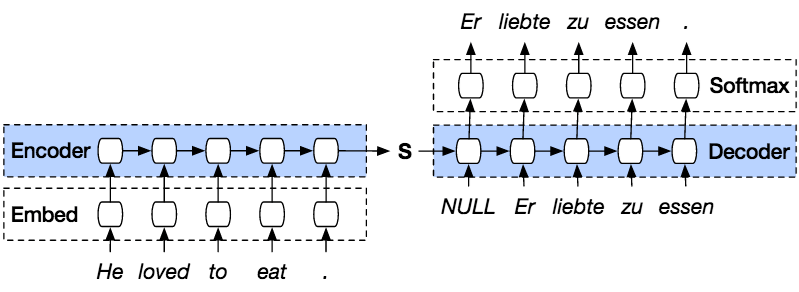

from: https://www.guru99.com/seq2seq-model.html

In [ ]:
model

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0): MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
   

# Goal ของ Seq2Seq
* รับ input ส่งเข้า Encoder แล้วอัดข้อมูลทุกอย่างให้เป็น S 
* ความคาดหวังคือ "S" จะมี information สำหรับการทำนาย
* จากนั้น Decoder มีหน้าที่รับ S มาทำนาย
* ทำงานแบบ "Order มีผลต่อผลลัพธ์" (บทเรียนที่ 1 RNN) ทั้ง Encoder และ Decoder ทำงานเหมือนกัน (Sequence ทั้งต้นและปลาย)
* ตัว Decoder จะทำนายได้เรื่อยๆ จนกว่าทำนายจนเจอ token บอกให้หยุด (บางครั้งก็กำหนดได้ว่าจะหยุดเมื่อไหร่เช่น ทำนายแค่ 1 ครั้งพอ อารมณ์เดียวกับ next word prediction)



# ฟังก์ชั่นพิเศษ DataCollatorForSeq2Seq

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

dict_keys(['attention_mask', 'input_ids', 'labels', 'decoder_input_ids'])

In [ ]:
batch['input_ids'][0]

tensor([47591,    12,  9842, 19634,     9,     0, 59513, 59513, 59513, 59513,
        59513, 59513, 59513, 59513, 59513])

In [ ]:
tokenizer.convert_ids_to_tokens(batch['input_ids'][0])

['▁Default',
 '▁to',
 '▁expanded',
 '▁thread',
 's',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [ ]:
batch['decoder_input_ids'][0]

tensor([59513,   577,  5891,     2,  3184,    16,  2542,     5,  1710,     0,
        59513, 59513, 59513, 59513, 59513, 59513])

In [ ]:
tokenizer.convert_ids_to_tokens(batch['decoder_input_ids'][0])

['<pad>',
 '▁Par',
 '▁défaut',
 ',',
 '▁développer',
 '▁les',
 '▁fils',
 '▁de',
 '▁discussion',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [ ]:
batch["labels"]

tensor([[  577,  5891,     2,  3184,    16,  2542,     5,  1710,     0,  -100,
          -100,  -100,  -100,  -100,  -100,  -100],
        [ 1211,     3,    49,  9409,  1211,     3, 29140,   817,  3124,   817,
           550,  7032,  5821,  7907, 12649,     0]])

In [ ]:
tokenizer.convert_ids_to_tokens(batch["labels"][0])

['▁Par',
 '▁défaut',
 ',',
 '▁développer',
 '▁les',
 '▁fils',
 '▁de',
 '▁discussion',
 '</s>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>']

# Input ของ Decoder
= เอา input ของ encoder มา right-shift หรือขยับไปด้านขวา 1 ช่อง เช่น 


```
Encoder = "ฉัน กิน ข้าว"
Decoder = "<start> ฉัน กิน ข้าว <end>"
```
(จากรูปข้างบนก็จะเห็นว่ามีการใส่ NULL เข้ามา)




# วิธีประเมินผลของโมเดล?
= ในงานการแปลภาษา เราจะใช้ "BLEU score" เป็นสกอร์ที่บอกว่าการแปลของเราใกล้เคียงกับเฉลยแค่ไหน โดยการเทียบ "ชุดของคำ โดยนำมาจาก เฉลย & จากการทำนาย" 

อ่านเพิ่มเติม: https://en.wikipedia.org/wiki/BLEU

In [ ]:
from datasets import load_metric

metric = load_metric("sacrebleu")

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

# ตย.1

In [ ]:
predictions = [
    "This plugin lets you translate web pages between several languages automatically."
]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'bp': 0.9200444146293233,
 'counts': [11, 6, 4, 3],
 'precisions': [91.66666666666667,
  54.54545454545455,
  40.0,
  33.333333333333336],
 'ref_len': 13,
 'score': 46.750469682990165,
 'sys_len': 12,
 'totals': [12, 11, 10, 9]}

# ตย.2

In [ ]:
predictions = ["This This This This"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'bp': 0.10539922456186433,
 'counts': [1, 0, 0, 0],
 'precisions': [25.0, 16.666666666666668, 12.5, 12.5],
 'ref_len': 13,
 'score': 1.683602693167689,
 'sys_len': 4,
 'totals': [4, 3, 2, 1]}

# ตย. 3

In [ ]:
predictions = ["plugin you web between languages"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'bp': 0.20189651799465538,
 'counts': [5, 0, 0, 0],
 'precisions': [100.0, 12.5, 8.333333333333334, 6.25],
 'ref_len': 13,
 'score': 3.225009698600463,
 'sys_len': 5,
 'totals': [5, 4, 3, 2]}

# จุดอ่อนของ BP

In [15]:
predictions = ["to plugin translate several you web This between languages allows pages"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

NameError: name 'metric' is not defined

In [ ]:
import numpy as np


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

In [ ]:
from transformers import Seq2SeqTrainingArguments

args = Seq2SeqTrainingArguments(
    f"marian-finetuned-kde4-en-to-fr",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True, # ถ้าใช้ GPU
    push_to_hub=True,
)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.47k/285M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.05k/3.05k [00:00<?, ?B/s]

Download file runs/Jan20_02-56-28_813f8d783f9b/events.out.tfevents.1642648752.813f8d783f9b.72.0:  55%|#####5  …

Download file runs/Jan20_02-56-28_813f8d783f9b/events.out.tfevents.1642651521.813f8d783f9b.72.2: 100%|########…

Clean file training_args.bin:  33%|###2      | 1.00k/3.05k [00:00<?, ?B/s]

Clean file runs/Jan20_02-56-28_813f8d783f9b/events.out.tfevents.1642648752.813f8d783f9b.72.0:  16%|#5        |…

Clean file runs/Jan20_02-56-28_813f8d783f9b/events.out.tfevents.1642651521.813f8d783f9b.72.2: 100%|##########|…

Download file runs/Jan20_02-56-28_813f8d783f9b/1642648752.5330608/events.out.tfevents.1642648752.813f8d783f9b.…

Clean file runs/Jan20_02-56-28_813f8d783f9b/1642648752.5330608/events.out.tfevents.1642648752.813f8d783f9b.72.…

Clean file pytorch_model.bin:   0%|          | 1.00k/285M [00:00<?, ?B/s]

Using amp half precision backend


In [ ]:
trainer.evaluate(max_length=max_target_length) # ก่อนเทรน สกอร์ก็ดีพอตัว

***** Running Evaluation *****
  Num examples = 21018
  Batch size = 64


{'eval_bleu': 39.27124165416069,
 'eval_loss': 1.6964441537857056,
 'eval_runtime': 1347.2741,
 'eval_samples_per_second': 15.6,
 'eval_steps_per_second': 0.244}

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 189155
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5912


Saving model checkpoint to marian-finetuned-kde4-en-to-fr/checkpoint-5912
Configuration saved in marian-finetuned-kde4-en-to-fr/checkpoint-5912/config.json
Model weights saved in marian-finetuned-kde4-en-to-fr/checkpoint-5912/pytorch_model.bin
tokenizer config file saved in marian-finetuned-kde4-en-to-fr/checkpoint-5912/tokenizer_config.json
Special tokens file saved in marian-finetuned-kde4-en-to-fr/checkpoint-5912/special_tokens_map.json
tokenizer config file saved in marian-finetuned-kde4-en-to-fr/tokenizer_config.json
Special tokens file saved in marian-finetuned-kde4-en-to-fr/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=5912, training_loss=1.123947184850463, metrics={'train_runtime': 1246.3041, 'train_samples_per_second': 151.773, 'train_steps_per_second': 4.744, 'total_flos': 3773950253531136.0, 'train_loss': 1.123947184850463, 'epoch': 1.0})

In [ ]:
trainer.evaluate(max_length=max_target_length) #จาก 39 => 50 !!

***** Running Evaluation *****
  Num examples = 21018
  Batch size = 64


{'epoch': 1.0,
 'eval_bleu': 50.20410659441166,
 'eval_loss': 0.9643106460571289,
 'eval_runtime': 1523.0974,
 'eval_samples_per_second': 13.8,
 'eval_steps_per_second': 0.216}

In [ ]:
trainer.push_to_hub(tags="translation", commit_message="Training complete") # อัพขึ้น hugging face

Saving model checkpoint to marian-finetuned-kde4-en-to-fr
Configuration saved in marian-finetuned-kde4-en-to-fr/config.json
Model weights saved in marian-finetuned-kde4-en-to-fr/pytorch_model.bin
tokenizer config file saved in marian-finetuned-kde4-en-to-fr/tokenizer_config.json
Special tokens file saved in marian-finetuned-kde4-en-to-fr/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.
To https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr
   6722933..a9aec84  main -> main

To https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr
   a9aec84..ba8bf15  main -> main



'https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/commit/a9aec8499fa2dc158869957189822bb6daed6b2d'

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "XXXX" # ลองโหลดโมเดลมาใช้
translator = pipeline("translation", model=model_checkpoint)

https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp75iu2h1l


Downloading:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/1c92fe3bf0b9fc397b3b68fed2eb636f7f5c3f006a9f0b044e449b477b9d4f7c.f39bd3c2362a84b75eb6d388a96515ed46798865b8f6377283b55bbb1996776d
creating metadata file for /root/.cache/huggingface/transformers/1c92fe3bf0b9fc397b3b68fed2eb636f7f5c3f006a9f0b044e449b477b9d4f7c.f39bd3c2362a84b75eb6d388a96515ed46798865b8f6377283b55bbb1996776d
loading configuration file https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/1c92fe3bf0b9fc397b3b68fed2eb636f7f5c3f006a9f0b044e449b477b9d4f7c.f39bd3c2362a84b75eb6d388a96515ed46798865b8f6377283b55bbb1996776d
Model config MarianConfig {
  "_name_or_path": "mrp/marian-finetuned-kde4-en-to-fr",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectu

Downloading:   0%|          | 0.00/285M [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/858f96e2318a8ab29a81191ea997225a0d8ceaa75ba7c294f39d632a1bc35d9c.b529404a954b1d8a67c658370448d9b176e190317e223f476e8141087bfa2d65
creating metadata file for /root/.cache/huggingface/transformers/858f96e2318a8ab29a81191ea997225a0d8ceaa75ba7c294f39d632a1bc35d9c.b529404a954b1d8a67c658370448d9b176e190317e223f476e8141087bfa2d65
loading weights file https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/858f96e2318a8ab29a81191ea997225a0d8ceaa75ba7c294f39d632a1bc35d9c.b529404a954b1d8a67c658370448d9b176e190317e223f476e8141087bfa2d65
All model checkpoint weights were used when initializing MarianMTModel.

All the weights of MarianMTModel were initialized from the model checkpoint at mrp/marian-finetuned-kde4-en-to-fr.
If your task is similar to the task the model of

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/ed3231b95a780739cc842aa29a93409c9dfbf2e3ba80885576a4e282c576d06b.3e2cb67f13186337b50025aa21e23e3239082196cba3fc46ed38bc79db27e477
creating metadata file for /root/.cache/huggingface/transformers/ed3231b95a780739cc842aa29a93409c9dfbf2e3ba80885576a4e282c576d06b.3e2cb67f13186337b50025aa21e23e3239082196cba3fc46ed38bc79db27e477
https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/source.spm not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp_25s3v0v


Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/source.spm in cache at /root/.cache/huggingface/transformers/c0a2d13852064e272a23fc09e1deb72e2a5cbc31b3ce66e428a655710cac0999.1a8b1c99c8359ed99f2d577f69114f5e285203705b08e5b9177f626b259660ec
creating metadata file for /root/.cache/huggingface/transformers/c0a2d13852064e272a23fc09e1deb72e2a5cbc31b3ce66e428a655710cac0999.1a8b1c99c8359ed99f2d577f69114f5e285203705b08e5b9177f626b259660ec
https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/target.spm not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpi8k0mhbw


Downloading:   0%|          | 0.00/784k [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/target.spm in cache at /root/.cache/huggingface/transformers/ace0835aa07e3b9ac9ae16fe078f6bdd34010d2ba31c7fe4e1a3725bd812b145.7a3fadd05a0cee82a22786164d20d49e7b313753bf53c7e219cd382f47c08871
creating metadata file for /root/.cache/huggingface/transformers/ace0835aa07e3b9ac9ae16fe078f6bdd34010d2ba31c7fe4e1a3725bd812b145.7a3fadd05a0cee82a22786164d20d49e7b313753bf53c7e219cd382f47c08871
https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/vocab.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpwo259mxq


Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/350b53a616e636856a2aca335d69b5a6f8669c6b68987619c97fb3b53a4eb997.f0e9eb9c8120de9b276d39c458593bb6f470220163cc5be81c17eabfd243816d
creating metadata file for /root/.cache/huggingface/transformers/350b53a616e636856a2aca335d69b5a6f8669c6b68987619c97fb3b53a4eb997.f0e9eb9c8120de9b276d39c458593bb6f470220163cc5be81c17eabfd243816d
https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpcd5dj2o8


Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/706ccba74244d26113decf63eed9126d5c77b14d348c94424157894a5162fa99.294ebaa4cd17bb284635004c92d2c4d522ec488c828dcce0c2471b6f28e3fe82
creating metadata file for /root/.cache/huggingface/transformers/706ccba74244d26113decf63eed9126d5c77b14d348c94424157894a5162fa99.294ebaa4cd17bb284635004c92d2c4d522ec488c828dcce0c2471b6f28e3fe82
loading file https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/source.spm from cache at /root/.cache/huggingface/transformers/c0a2d13852064e272a23fc09e1deb72e2a5cbc31b3ce66e428a655710cac0999.1a8b1c99c8359ed99f2d577f69114f5e285203705b08e5b9177f626b259660ec
loading file https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/target.spm from cache at /root/.cache/huggingface/transformers/ace0835aa07e3b9ac9ae16fe078f6bdd34010d2ba31c7fe4e1a3725bd812b145.7a3fadd05a0cee82a22786164d20d49e7

[{'translation_text': 'Par défaut pour les fils de discussion étendus'}]

In [ ]:
translator("Default to expanded threads")

[{'translation_text': 'Par défaut pour les fils de discussion étendus'}]